In [46]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from IPython.display import clear_output, display, HTML
import urllib.request
from collections import Counter
import matplotlib.pyplot as plt



# Descarga del **dataset**

In [47]:
urllib.request.urlretrieve("https://drive.usercontent.google.com/download?id=1S2rBtlONWMG2t2aXUBu651s27zFqIHPr&export=download&authuser=0&confirm=t&uuid=93c00f5c-a0b5-4cee-a111-569330013491&at=AENtkXYVY3zj6r4LR6X7sAx8Kw8n%3A1732468742225", "converted.csv")

# En caso de no funcionar la descaga descargar manualmente desde https://drive.google.com/file/d/1S2rBtlONWMG2t2aXUBu651s27zFqIHPr y guardarlo bajo el nombre converted.csv

('converted.csv', <http.client.HTTPMessage at 0x260475aa900>)

# Adecuación del dataset

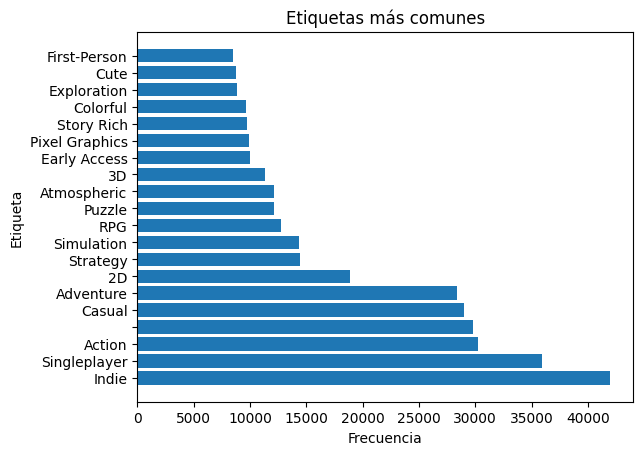

In [48]:
# Leemos el archivo
df = pd.read_csv('converted.csv') 

# Seleccionamos las columnas que nos interesan
df = df[['Name', 'Genres', 'Tags', 'Categories', 'Positive', 'Negative', 'Header image', 'Metacritic score']]

df = df.fillna('')


# Contar las etiquetas mas comunes
tags = df['Tags'].str.split(',')  # Divide las etiquetas
all_tags = [tag.strip() for sublist in tags.dropna() for tag in sublist]
tag_counts = Counter(all_tags).most_common(20)  # Las 20 más comunes

# Gráfico de barras
plt.barh([tag[0] for tag in tag_counts], [tag[1] for tag in tag_counts])
plt.xlabel("Frecuencia")
plt.ylabel("Etiqueta")
plt.title("Etiquetas más comunes")
plt.show()

# Dividimos las etiquetas
for col in ['Genres', 'Tags', 'Categories']:
    df[col] = df[col].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
    
    
# Creamos una nueva columna con las características combinadas
df['combined_features'] = df['Genres'].apply(lambda x: ' '.join(x)) + ' ' + \
                          df['Tags'].apply(lambda x: ' '.join(x)) + ' ' + \
                          df['Categories'].apply(lambda x: ' '.join(x))

# Algoritmo de recomendación

In [49]:
# Crear el vectorizador TF-IDF
tfidf = TfidfVectorizer(stop_words='english')

# Convertir las características combinadas en una matriz TF-IDF
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

# Configurar el modelo para encontrar los k vecinos más cercanos
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
knn.fit(tfidf_matrix)

# Función para recomendar juegos
def recommend_games_knn(title):
    try:
        idx = df[df['Name'] == title].index[0]
    except IndexError:
        return []
    distances, indices = knn.kneighbors(tfidf_matrix[idx])
    recommended_games = df.iloc[indices[0][1:]]['Name'].tolist()
    return recommended_games


def recommend_from_likes(game_names):

    if not game_names:
        print('No tienes juegos para generar recomendaciones')

    # Utilizamos un diccionario para almacenar los juegos sin duplicados, 
    # la clave es el nombre del juego y el valor es el objeto con sus detalles
    unique_games = {}

    # Generar recomendaciones para todos los juegos likeados
    for game_name in game_names:
        recommendations = recommend_games_knn(game_name)
        
        # Para cada recomendación, obtener el nombre, imagen y puntaje de Metacritic
        for rec in recommendations:
            game = df[df['Name'] == rec]
            if not game.empty:
                game_data = game.iloc[0]
                game_name = game_data['Name']
                
                # Solo agregamos el juego si no está ya en el diccionario o si tiene un puntaje Metacritic más alto
                if game_name not in unique_games or game_data['Metacritic score'] > unique_games[game_name]['metacritic_score']:
                    unique_games[game_name] = {
                        'name': game_name,
                        'metacritic_score': game_data['Metacritic score']
                    }

    # Convertir el diccionario a una lista y ordenar por Metacritic Score de manera descendente
    recommended_data = list(unique_games.values())
    recommended_data.sort(key=lambda x: x['metacritic_score'], reverse=True)

    # Devolver solo los 10 mejores juegos sin el Metacritic score
    recommendations = [{'name': game['name']} for game in recommended_data[:10]]
    
    for game in recommendations:
        print(game['name'])


# Prueba con juegos

In [50]:
recommend_from_likes(['Counter-Strike: Global Offensive', 'Grand Theft Auto V', 'The Witcher 3: Wild Hunt'])

Red Dead Redemption 2
Team Fortress 2
Grand Theft Auto IV: The Complete Edition
Left 4 Dead 2
DiRT Rally
Risk of Rain 2
Saints Row: The Third
HITMAN™ 2
Dungeon Defenders
MORDHAU
